<a href="https://colab.research.google.com/github/DeemonDuck/codealpha_tasks/blob/main/Emotion_Recognition_From_Speech_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting up the Kaggle API key
import os

!mkdir -p ~/.kaggle

!cp "/content/drive/MyDrive/CODEALPHA_PROJECTS/SPEECH_EMOTION_RECOGNITION/kaggle.json" ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle key is set up.")

Kaggle key is set up.


In [ ]:
!cp "/content/drive/MyDrive/CODEALPHA_PROJECTS/SPEECH_EMOTION_RECOGNITION/ravdess-emotional-speech-audio.zip" .

!unzip -q ravdess-emotional-speech-audio.zip -d ./ravdess_data

print("Dataset copied from Drive and unzipped into 'ravdess_data' folder!")

Dataset copied from Drive and unzipped into 'ravdess_data' folder!


In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')


DATA_PATH = "./ravdess_data/"

TARGET_SR = 22050

N_MELS = 128

MAX_PAD_LEN = 250

In [ ]:
file_paths = []
emotions = []
actors = []

# Map emotion codes to names (from RAVDESS documentation)
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

print("Parsing filenames...")
for dir in os.listdir(DATA_PATH):
    if dir.startswith("Actor_"):
        actor_dir_path = os.path.join(DATA_PATH, dir)
        for file in os.listdir(actor_dir_path):
            if file.endswith(".wav"):
                file_path = os.path.join(actor_dir_path, file)
                parts = file.split('.')[0].split('-')
                emotion_code = parts[2]
                actor_id = int(parts[6])
                if emotion_code in emotion_map:
                    file_paths.append(file_path)
                    emotions.append(emotion_map[emotion_code])
                    actors.append(actor_id)

print(f"Parsed {len(file_paths)} audio files.")

df = pd.DataFrame({
    'path': file_paths,
    'emotion': emotions,
    'actor': actors
})


print("\nDataFrame created:")
print(df.head())
print("\nEmotion distribution:")
print(df['emotion'].value_counts())

Parsing filenames...
Parsed 1440 audio files.

DataFrame created:
                                               path  emotion  actor
0  ./ravdess_data/Actor_22/03-01-05-01-02-02-22.wav    angry     22
1  ./ravdess_data/Actor_22/03-01-03-01-02-01-22.wav    happy     22
2  ./ravdess_data/Actor_22/03-01-03-02-01-02-22.wav    happy     22
3  ./ravdess_data/Actor_22/03-01-02-01-01-02-22.wav     calm     22
4  ./ravdess_data/Actor_22/03-01-07-01-02-02-22.wav  disgust     22

Emotion distribution:
emotion
angry        192
happy        192
calm         192
disgust      192
surprised    192
fearful      192
sad          192
neutral       96
Name: count, dtype: int64


In [ ]:
def get_features(path):
    try:
        y, sr = librosa.load(path, sr=TARGET_SR)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
        S_db = librosa.power_to_db(S, ref=np.max)
        if S_db.shape[1] > MAX_PAD_LEN:
            S_db = S_db[:, :MAX_PAD_LEN]
        else:
            pad_width = MAX_PAD_LEN - S_db.shape[1]
            S_db = np.pad(S_db, pad_width=((0, 0), (0, pad_width)), mode='constant')
    except Exception as e:
        print(f"Error processing {path}: {e}")
        return None
    return S_db

print("\nExtracting Mel Spectrogram features...")
X = []
for path in tqdm(df['path']):
    features = get_features(path)
    if features is not None:
        X.append(features)

X = np.array(X)
print(f"\nFeature extraction complete. Shape of X: {X.shape}")

le = LabelEncoder()
y = le.fit_transform(df['emotion'])
print(f"\nLabels created. Shape of y: {y.shape}")
print(f"Emotion labels mapping: {list(zip(le.classes_, range(len(le.classes_))))}")

X = X.reshape(X.shape[0], N_MELS, MAX_PAD_LEN, 1)
print(f"Reshaped X for CNN input: {X.shape}")


Extracting Mel Spectrogram features...


  0%|          | 0/1440 [00:00<?, ?it/s]


Feature extraction complete. Shape of X: (1440, 128, 250)

Labels created. Shape of y: (1440,)
Emotion labels mapping: [('angry', 0), ('calm', 1), ('disgust', 2), ('fearful', 3), ('happy', 4), ('neutral', 5), ('sad', 6), ('surprised', 7)]
Reshaped X for CNN input: (1440, 128, 250, 1)


In [ ]:
## Creating Speaker-Independent Data Split

from sklearn.model_selection import train_test_split
import numpy as np

actors = df['actor'].values

test_actors = [21, 22, 23, 24]

# Creating boolean masks for splitting
train_mask = ~np.isin(actors, test_actors) # Use '~' for NOT IN
test_mask = np.isin(actors, test_actors)

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

actors_train = actors[train_mask]
actors_test = actors[test_mask]

# Converting labels to categorical (one-hot encoding)
num_classes = len(np.unique(y))
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)


print("--- Data Shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test_cat shape: {y_test_cat.shape}")

print(f"\nUnique actors in training set: {np.unique(actors_train)}")
print(f"Unique actors in testing set: {np.unique(actors_test)}")
print(f"\nNumber of classes: {num_classes}")

--- Data Shapes ---
X_train shape: (1200, 128, 250, 1)
y_train_cat shape: (1200, 8)
X_test shape: (240, 128, 250, 1)
y_test_cat shape: (240, 8)

Unique actors in training set: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
Unique actors in testing set: [21 22 23 24]

Number of classes: 8


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)
input_shape = (N_MELS, MAX_PAD_LEN, 3)
print(f"Shape after repeating channels: {X_train_rgb.shape}")

# Loading the base model
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

base_model.trainable = False
print(f"Base model loaded. Trainable: {base_model.trainable}")

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])


optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel built successfully:")
model.summary()

Shape after repeating channels: (1200, 128, 250, 3)
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Base model loaded. Trainable: False

Model built successfully:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,683 (16.73 MB)

 Trainable params: 332,552 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
# Training the Model with Callbacks

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_emotion_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

epochs = 50
batch_size = 32

print("\nStarting model training...")
history = model.fit(
    X_train_rgb, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_rgb, y_test_cat),
    callbacks=[early_stopping, model_checkpoint]
)

print("\nTraining complete.")


Starting model training...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 57s 781ms/step - accuracy: 0.2334 - loss: 2.4691 - val_accuracy: 0.2333 - val_loss: 1.9558
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - accuracy: 0.3412 - loss: 2.1577 - val_accuracy: 0.3667 - val_loss: 1.9047
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.3831 - loss: 1.8409 - val_accuracy: 0.3458 - val_loss: 1.8692
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.4007 - loss: 1.8092 - val_accuracy: 0.3792 - val_loss: 1.8328
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.4098 - loss: 1.7289 - val_accuracy: 0.3958 - val_loss: 1.7680
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4154 - loss: 1.6426 - val_accuracy: 0.4000 - val_loss: 1.7396
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.4276 - loss: 1.5754 - val_accuracy: 0.4167 - val_loss: 1.7353
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4495 - loss: 1.5

In [ ]:
# Evaluating the Model on the Test Set

print("Evaluating the model on the test set...")
loss, accuracy = model.evaluate(X_test_rgb, y_test_cat, verbose=0)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

Evaluating the model on the test set...

Test Loss: 1.7257
Test Accuracy: 47.50%



Plotting training history...


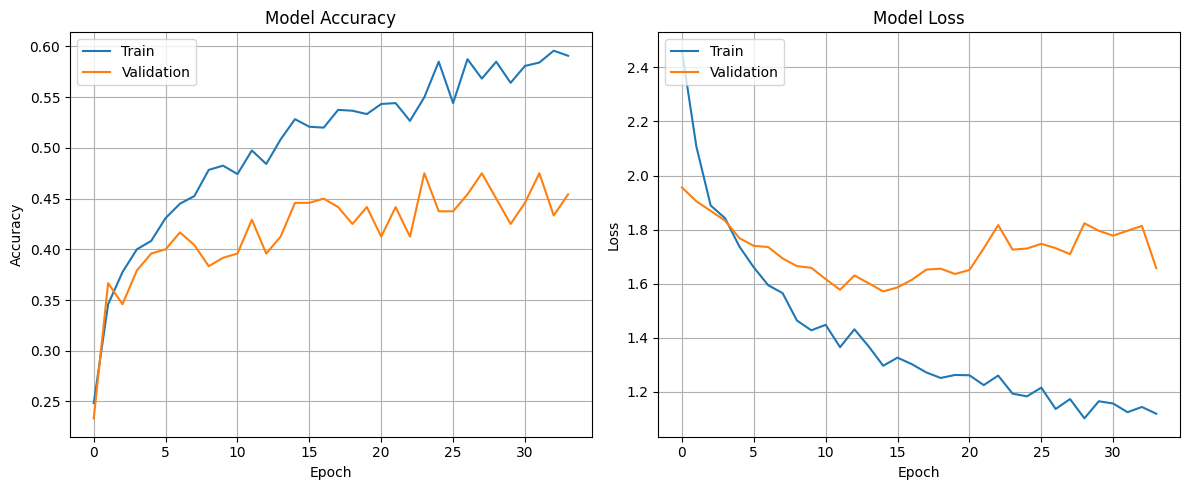

In [ ]:
import matplotlib.pyplot as plt

print("\nPlotting training history...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Validation'], loc='upper left')
ax1.grid(True)

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(['Train', 'Validation'], loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()

### Trying to improve accuracy by
1. Unfreezing the Base Layers in NetEfficientBO Model
2. Lowering the Learning Rate

In [ ]:
# Preparing for Fine-Tuning

print("Loading weights from best model...")
model.load_weights('best_emotion_model.keras')

#  Unfreeze the base model
print("Unfreezing base model layers...")
base_model.trainable = True

print(f"Number of layers in the base model: {len(base_model.layers)}")
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

fine_tune_lr = 0.00001 # 1e-5
optimizer = Adam(learning_rate=fine_tune_lr)

print(f"Re-compiling model with learning rate: {fine_tune_lr}")
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Printing model summary again (shows more trainable params now)
model.summary()

Loading weights from best model...
Unfreezing base model layers...
Number of layers in the base model: 238
Re-compiling model with learning rate: 1e-05


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,683 (16.73 MB)

 Trainable params: 4,172,900 (15.92 MB)

 Non-trainable params: 211,783 (827.28 KB)

In [ ]:
fine_tune_epochs = 20

initial_epoch = len(history.history['loss'])

print(f"\nStarting fine-tuning from epoch {initial_epoch}...")

# Continue training
history_fine = model.fit(
    X_train_rgb, y_train_cat,
    epochs=initial_epoch + fine_tune_epochs,
    initial_epoch=initial_epoch,
    batch_size=batch_size,                  # Can potentially reduce batch size if memory becomes an issue which is in Google Collab
    validation_data=(X_test_rgb, y_test_cat),
    callbacks=[early_stopping, model_checkpoint] # Same callbacks (saving best weights)
)

print("\nFine-tuning complete.")

# Loading the absolute best weights again
print("Loading best weights achieved during fine-tuning...")
model.load_weights('best_emotion_model.keras')


Starting fine-tuning from epoch 34...
Epoch 35/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.1124 - loss: 2.8323 - val_accuracy: 0.2958 - val_loss: 2.1870
Epoch 36/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.1695 - loss: 2.5841 - val_accuracy: 0.2625 - val_loss: 2.3130
Epoch 37/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.2167 - loss: 2.3028 - val_accuracy: 0.1958 - val_loss: 2.4151
Epoch 38/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.2003 - loss: 2.2549 - val_accuracy: 0.1917 - val_loss: 2.3332
Epoch 39/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.2690 - loss: 2.0401 - val_accuracy: 0.2083 - val_loss: 2.1528
Epoch 40/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.3139 - loss: 1.9604 - val_accuracy: 0.2333 - val_loss: 2.0284
Epoch 41/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - accuracy: 0.3373 - loss: 1.7885 - val_accuracy: 0.2333 - val_loss: 1.9576
Epoch 42/54
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.

In [ ]:
# Evaluating the Model on the Test Set

print("Evaluating the final model on the test set...")
loss, accuracy = model.evaluate(X_test_rgb, y_test_cat, verbose=0)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

Evaluating the final model on the test set...

Test Loss: 1.7257
Test Accuracy: 47.50%


In [ ]:
# Copying the Best Model File to Google Drive

drive_save_path = "/content/drive/MyDrive/CODEALPHA_PROJECTS/SPEECH_EMOTION_RECOGNITION/"

!cp best_emotion_model.keras "{drive_save_path}"

print(f"Latest best model saved to Google Drive at: {drive_save_path}")

Latest best model saved to Google Drive at: /content/drive/MyDrive/CODEALPHA_PROJECTS/SPEECH_EMOTION_RECOGNITION/


## Accuracy didn't improve even after fine tuning in only CNN model.
 Possible resons that this is happening:
 1. Overfitting
 2. Lack of Temporal Modeling
 3. Suboptimal Features

Trying CRNN with LSTM to get better reslts

In [ ]:
# Building the CRNN Model

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Reshape, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

# --- Prepare 3-Channel Input Data (as before) ---
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)
input_shape = (N_MELS, MAX_PAD_LEN, 3) # (128, 250, 3)
print(f"Input shape for model: {input_shape}")
print(f"X_train_rgb shape: {X_train_rgb.shape}")

base_model_cnn = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

# Freeze the base model layers initially
base_model_cnn.trainable = False

temp_model = Sequential([base_model_cnn])
cnn_output_shape = temp_model.predict(X_train_rgb[0:1]).shape # Predict on one sample
print(f"CNN base output shape (per sample): {cnn_output_shape[1:]}") # Exclude batch dim

h_cnn, w_cnn, c_cnn = cnn_output_shape[1:]
lstm_timesteps = w_cnn
lstm_features = h_cnn * c_cnn
reshape_target = (lstm_timesteps, lstm_features) # e.g., (8, 4 * 1280)
print(f"Reshaping CNN output to: (timesteps={lstm_timesteps}, features={lstm_features})")


# --- Building the CRNN model ---
model = Sequential([
    base_model_cnn,                      # CNN Feature Extractor
    Reshape(target_shape=reshape_target),# Reshape for LSTM
    LSTM(128, return_sequences=False),   # LSTM layer (only return final output)
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') # Output layer
])

optimizer = Adam(learning_rate=0.001) # Start with a standard LR
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nCRNN Model built successfully:")
model.summary()

Input shape for model: (128, 250, 3)
X_train_rgb shape: (1200, 128, 250, 3)
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
CNN base output shape (per sample): (4, 8, 1280)
Reshaping CNN output to: (timesteps=8, features=5120)

CRNN Model built successfully:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 4, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 5120)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │     2,687,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,755,115 (25.77 MB)

 Trainable params: 2,705,288 (10.32 MB)

 Non-trainable params: 4,049,827 (15.45 MB)

In [ ]:
# Training the Model with Callbacks

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_emotion_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

epochs = 50
batch_size = 32

print("\nStarting CRNN model training...")
history = model.fit(
    X_train_rgb, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_rgb, y_test_cat),
    callbacks=[early_stopping, model_checkpoint]
)

print("\nTraining complete.")


Starting CRNN model training...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 23s 226ms/step - accuracy: 0.1894 - loss: 2.3340 - val_accuracy: 0.1458 - val_loss: 2.0405
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.2315 - loss: 1.9916 - val_accuracy: 0.1333 - val_loss: 1.9955
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.2444 - loss: 1.9118 - val_accuracy: 0.1958 - val_loss: 1.9968
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.3385 - loss: 1.7931 - val_accuracy: 0.2083 - val_loss: 1.9140
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - accuracy: 0.3549 - loss: 1.7531 - val_accuracy: 0.3042 - val_loss: 1.8677
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.3454 - loss: 1.6791 - val_accuracy: 0.2458 - val_loss: 1.9085
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.3866 - loss: 1.6061 - val_accuracy: 0.3875 - val_loss: 1.6998
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.4268 - loss

In [ ]:
# Evaluating the Model on the Test Set

print("Evaluating the CRNN model on the test set...")
loss, accuracy = model.evaluate(X_test_rgb, y_test_cat, verbose=0)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

final_crnn_accuracy = accuracy
final_crnn_loss = loss

Evaluating the CRNN model on the test set...

Test Loss: 1.6454
Test Accuracy: 45.83%



Plotting CRNN training history...


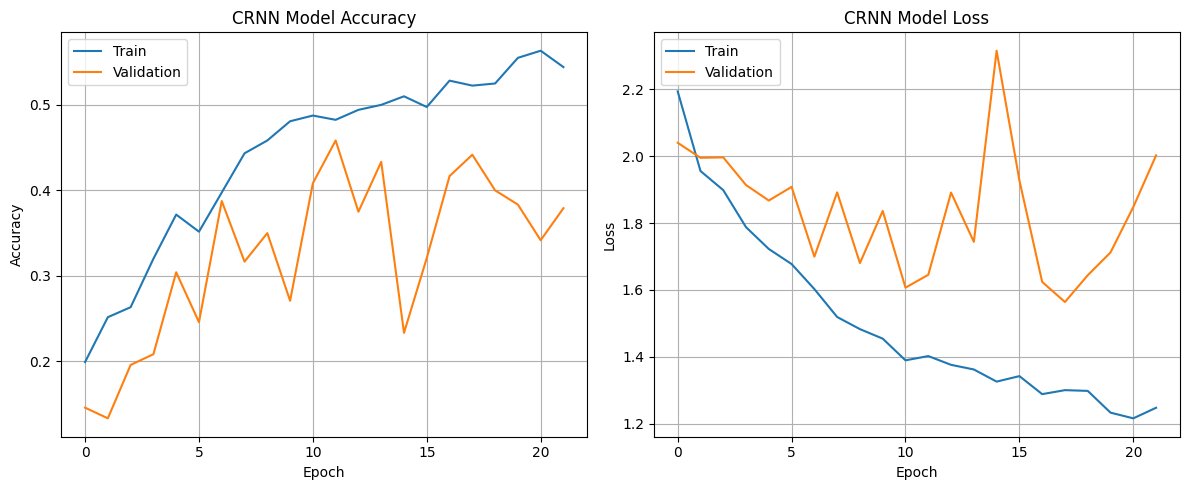

In [ ]:
## Cell 11: Plot Training & Validation History

import matplotlib.pyplot as plt

print("\nPlotting CRNN training history...")

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

if 'history' in locals() and history is not None and history.history:
    # Plot training & validation accuracy values
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        ax1.plot(history.history['accuracy'])
        ax1.plot(history.history['val_accuracy'])
        ax1.set_title('CRNN Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Train', 'Validation'], loc='upper left')
        ax1.grid(True)
    else:
        ax1.set_title('Accuracy data not available')

    # Plot training & validation loss values
    if 'loss' in history.history and 'val_loss' in history.history:
        ax2.plot(history.history['loss'])
        ax2.plot(history.history['val_loss'])
        ax2.set_title('CRNN Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Train', 'Validation'], loc='upper left')
        ax2.grid(True)
    else:
        ax2.set_title('Loss data not available')

    plt.tight_layout()
    plt.show()
else:
    print("No training history found to plot.")

Accuracy didn't improve. Model is still overfitting and we can see the instability between the Training Accuracy and Validation Accuracy

## CRNN Model with Basic Augmentation Layer
### I've added GaussianNoise as a simpler starting point for augmentation. Full SpecAugment using tfa.image.random_cutout might need adjustments depending on how it handles the spectrogram dimensions versus typical image dimensions.

In [ ]:
# Building CRNN Model with Keras Augmentation

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (GlobalAveragePooling2D, Dense, Dropout,
                                     BatchNormalization, Reshape, LSTM, Layer, Input,
                                     GaussianNoise)
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np

# --- Prepare 3-Channel Input Data (as before) ---
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)
input_shape = (N_MELS, MAX_PAD_LEN, 3) # (128, 250, 3)
print(f"Input shape for model: {input_shape}")

# --- Load the base CNN model ---
base_model_cnn = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)
base_model_cnn.trainable = False # Keep frozen for now

temp_model = Sequential([Input(shape=input_shape), base_model_cnn]) # Use Input layer
cnn_output_shape = temp_model.predict(X_train_rgb[0:1]).shape
# Handle potential dimension mismatch if predict includes batch size
if len(cnn_output_shape) == 4:
    h_cnn, w_cnn, c_cnn = cnn_output_shape[1:]
elif len(cnn_output_shape) == 3: # If predict doesn't return batch dim
     h_cnn, w_cnn, c_cnn = cnn_output_shape
else:
    raise ValueError(f"Unexpected CNN output shape: {cnn_output_shape}")

lstm_timesteps = w_cnn
lstm_features = h_cnn * c_cnn
reshape_target = (lstm_timesteps, lstm_features)
print(f"CNN base output shape (per sample): ({h_cnn}, {w_cnn}, {c_cnn})")
print(f"Reshaping CNN output to: (timesteps={lstm_timesteps}, features={lstm_features})")

model = Sequential([
    Input(shape=input_shape),            # Define input layer explicitly
    GaussianNoise(0.1),                  # Add noise during training (from tf.keras.layers)
    base_model_cnn,                      # CNN Feature Extractor
    Reshape(target_shape=reshape_target),# Reshape for LSTM
    LSTM(128, return_sequences=False),   # LSTM layer
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') # Output layer
])

optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nAugmented CRNN Model built successfully:")
model.summary()

Input shape for model: (128, 250, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
CNN base output shape (per sample): (4, 8, 1280)
Reshaping CNN output to: (timesteps=8, features=5120)

Augmented CRNN Model built successfully:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 128, 250, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 8, 5120)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │     2,687,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,755,115 (25.77 MB)

 Trainable params: 2,705,288 (10.32 MB)

 Non-trainable params: 4,049,827 (15.45 MB)

In [ ]:
# Training the Model with Callbacks

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_emotion_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

epochs = 50
batch_size = 32

print("\nStarting CRNN model training...")
history = model.fit(
    X_train_rgb, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_rgb, y_test_cat),
    callbacks=[early_stopping, model_checkpoint]
)

print("\nTraining complete.")


Starting CRNN model training...
Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 173ms/step - accuracy: 0.1737 - loss: 2.3684 - val_accuracy: 0.1333 - val_loss: 2.0978
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.2666 - loss: 1.9919 - val_accuracy: 0.1458 - val_loss: 2.0630
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 0.2382 - loss: 1.9269 - val_accuracy: 0.2500 - val_loss: 1.9102
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.3126 - loss: 1.8112 - val_accuracy: 0.2583 - val_loss: 1.8905
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.3649 - loss: 1.7222 - val_accuracy: 0.3792 - val_loss: 1.7292
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.3907 - loss: 1.6540 - val_accuracy: 0.3750 - val_loss: 1.7686
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 95ms/step - accuracy: 0.4346 - loss: 1.5742 - val_accuracy: 0.4208 - val_loss: 1.6470
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.4098 - lo

In [ ]:
## Evaluating the Model on the Test Set

print("Evaluating the CRNN model on the test set...")
loss, accuracy = model.evaluate(X_test_rgb, y_test_cat, verbose=0)

print(f"\nTest Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

final_crnn_accuracy = accuracy
final_crnn_loss = loss

Evaluating the CRNN model on the test set...

Test Loss: 2.0059
Test Accuracy: 44.58%



Plotting CRNN training history...


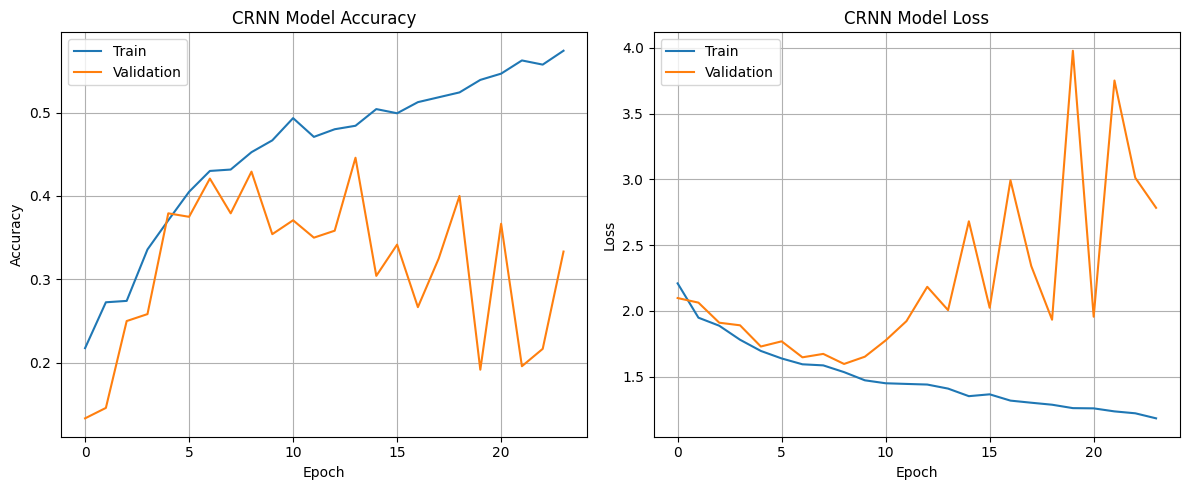

In [ ]:
# Plot Training & Validation History

import matplotlib.pyplot as plt

print("\nPlotting CRNN training history...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Check if history object exists and has data
if 'history' in locals() and history is not None and history.history:
    # Plot training & validation accuracy values
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        ax1.plot(history.history['accuracy'])
        ax1.plot(history.history['val_accuracy'])
        ax1.set_title('CRNN Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Train', 'Validation'], loc='upper left')
        ax1.grid(True)
    else:
        ax1.set_title('Accuracy data not available')

    # Plot training & validation loss values
    if 'loss' in history.history and 'val_loss' in history.history:
        ax2.plot(history.history['loss'])
        ax2.plot(history.history['val_loss'])
        ax2.set_title('CRNN Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Train', 'Validation'], loc='upper left')
        ax2.grid(True)
    else:
        ax2.set_title('Loss data not available')

    plt.tight_layout()
    plt.show()
else:
    print("No training history found to plot.")

# Model Is very Unstable Trying A different Approach

##Conclusion
Adding GaussianNoise augmentation to the CRNN model (with the EfficientNet base still frozen) did not improve performance and actually seemed to make the training less stable, resulting in slightly worse generalization

Lets's try the **YAMNet** approach. This involves using the pre-trained YAMNet model to convert our audio clips into meaningful numerical representations (embeddings), and then training a new, simpler classifier on those embeddings.

In [ ]:
## Loading YAMNet from TensorFlow Hub

import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import librosa
from tqdm.notebook import tqdm

print("Loading YAMNet model from TensorFlow Hub...")
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)
print("YAMNet model loaded.")

# Defining YAMNet's expected input sample rate
YAMNET_SR = 16000

Loading YAMNet model from TensorFlow Hub...
YAMNet model loaded.


In [ ]:
# Extracting YAMNet Embeddings

def extract_yamnet_embeddings(file_path):
    """Loads audio, resamples, and extracts mean YAMNet embedding."""
    try:
        # Load audio, resample to 16 kHz, ensure mono
        wav_data, sr = librosa.load(file_path, sr=YAMNET_SR, mono=True)
m
        _, embeddings, _ = yamnet_model(wav_data)

        # Calculating the mean embedding across the frames
        mean_embeddings = np.mean(embeddings.numpy(), axis=0)
        return mean_embeddings

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Extracting embeddings for all files
print("\nExtracting YAMNet embeddings for all audio files...")
# Using the original DataFrame 'df' which has file paths
all_embeddings = []
for file_path in tqdm(df['path']):
    embedding = extract_yamnet_embeddings(file_path)
    if embedding is not None:
        all_embeddings.append(embedding)

X_yamnet = np.array(all_embeddings)

print(f"\nYAMNet embedding extraction complete. Shape: {X_yamnet.shape}")

X_train_yamnet = X_yamnet[train_mask]
X_test_yamnet = X_yamnet[test_mask]

print(f"X_train_yamnet shape: {X_train_yamnet.shape}")
print(f"X_test_yamnet shape: {X_test_yamnet.shape}")
print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"y_test_cat shape: {y_test_cat.shape}")


Extracting YAMNet embeddings for all audio files...


  0%|          | 0/1440 [00:00<?, ?it/s]


YAMNet embedding extraction complete. Shape: (1440, 1024)
X_train_yamnet shape: (1200, 1024)
X_test_yamnet shape: (240, 1024)
y_train_cat shape: (1200, 8)
y_test_cat shape: (240, 8)


In [ ]:
## Building Classifier on YAMNet Embeddings

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_input_shape = (X_train_yamnet.shape[1],)

yamnet_classifier = Sequential([
    Input(shape=embedding_input_shape),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
yamnet_classifier.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Classifier model for YAMNet embeddings built:")
yamnet_classifier.summary()

Classifier model for YAMNet embeddings built:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 297,864 (1.14 MB)

 Trainable params: 297,096 (1.13 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
## Cell (New): Train the YAMNet Classifier

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15, # Maybe slightly more patience for this simpler model
    restore_best_weights=True
)

yamnet_checkpoint = ModelCheckpoint(
    'best_yamnet_classifier.keras', # New filename for this model
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

epochs = 100
batch_size = 32

print("\nStarting training for the classifier on YAMNet embeddings...")

history_yamnet = yamnet_classifier.fit(
    X_train_yamnet, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_yamnet, y_test_cat),
    callbacks=[early_stopping, yamnet_checkpoint]
)

print("\nClassifier training complete.")

print("Loading best weights achieved during training...")
yamnet_classifier.load_weights('best_yamnet_classifier.keras')


Starting training for the classifier on YAMNet embeddings...
Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - accuracy: 0.1464 - loss: 3.1629 - val_accuracy: 0.1458 - val_loss: 3.5993
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2047 - loss: 2.4930 - val_accuracy: 0.1417 - val_loss: 2.8357
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2636 - loss: 2.3752 - val_accuracy: 0.1917 - val_loss: 2.1291
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2588 - loss: 2.2961 - val_accuracy: 0.1250 - val_loss: 2.1154
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3047 - loss: 2.1451 - val_accuracy: 0.2750 - val_loss: 1.8856
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2397 - loss: 2.1732 - val_accuracy: 0.1625 - val_loss: 2.2727
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2643 - loss: 2.1416 - val_accuracy: 0.2708 - val_loss: 1.8968
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/st

In [ ]:
print("Evaluating the YAMNet classifier on the test set embeddings...")

loss, accuracy = yamnet_classifier.evaluate(X_test_yamnet, y_test_cat, verbose=0)

print(f"\nTest Loss (YAMNet): {loss:.4f}")
print(f"Test Accuracy (YAMNet): {accuracy*100:.2f}%")

final_yamnet_accuracy = accuracy
final_yamnet_loss = loss

Evaluating the YAMNet classifier on the test set embeddings...

Test Loss (YAMNet): 1.8856
Test Accuracy (YAMNet): 27.50%


# I am trying one more attempt with YAMNet, but this time using the sequence of embeddings + LSTM.

In [ ]:
## Extracting YAMNet Embedding Sequences

import tensorflow_hub as hub
import tensorflow as tf
import numpy as np
import librosa
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("Loading YAMNet model...")
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)
YAMNET_SR = 16000
print("YAMNet model loaded.")

# --- Define Sequence Length ---
MAX_SEQ_LEN = 10
EMBEDDING_SIZE = 1024

def extract_yamnet_embedding_sequence(file_path):
    """Loads audio, gets sequence of YAMNet embeddings, pads/truncates."""
    try:
        wav_data, sr = librosa.load(file_path, sr=YAMNET_SR, mono=True)
        # Get embeddings sequence
        _, embeddings, _ = yamnet_model(wav_data)
        embeddings_np = embeddings.numpy() # Shape: (num_frames, 1024)

        # Pad or truncate the sequence
        padded_embeddings = pad_sequences(
            [embeddings_np],
            maxlen=MAX_SEQ_LEN,
            dtype='float32',
            padding='post', # Pad at the end
            truncating='post' # Truncate at the end
        )[0]
        return padded_embeddings

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# --- Extract sequences for all files ---
print(f"\nExtracting YAMNet sequences (max len {MAX_SEQ_LEN})...")
all_sequences = []
for file_path in tqdm(df['path']):
    sequence = extract_yamnet_embedding_sequence(file_path)
    if sequence is not None:
        all_sequences.append(sequence)

X_yamnet_seq = np.array(all_sequences)
print(f"\nYAMNet sequence extraction complete. Shape: {X_yamnet_seq.shape}")

X_train_yamnet_seq = X_yamnet_seq[train_mask]
X_test_yamnet_seq = X_yamnet_seq[test_mask]

# Labels (y_train_cat, y_test_cat) remain the same
print(f"X_train_yamnet_seq shape: {X_train_yamnet_seq.shape}")
print(f"X_test_yamnet_seq shape: {X_test_yamnet_seq.shape}")
print(f"y_train_cat shape: {y_train_cat.shape}")
print(f"y_test_cat shape: {y_test_cat.shape}")

Loading YAMNet model...
YAMNet model loaded.

Extracting YAMNet sequences (max len 10)...


  0%|          | 0/1440 [00:00<?, ?it/s]


YAMNet sequence extraction complete. Shape: (1440, 10, 1024)
X_train_yamnet_seq shape: (1200, 10, 1024)
X_test_yamnet_seq shape: (240, 10, 1024)
y_train_cat shape: (1200, 8)
y_test_cat shape: (240, 8)


In [ ]:
## Building` LSTM Classifier on YAMNet Sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Masking, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Defining input shape for the sequence
sequence_input_shape = (MAX_SEQ_LEN, EMBEDDING_SIZE)

yamnet_lstm_classifier = Sequential([
    Input(shape=sequence_input_shape),
    # Masking layer ignores padded steps (where input is all zeros)
    Masking(mask_value=0.0),
    LSTM(128, return_sequences=False), # Process sequence, return final output
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax') # num_classes is still 8
])

optimizer = Adam(learning_rate=0.001)
yamnet_lstm_classifier.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("LSTM classifier model for YAMNet sequences built:")
yamnet_lstm_classifier.summary()

LSTM classifier model for YAMNet sequences built:


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 10, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 128)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 608,392 (2.32 MB)

 Trainable params: 608,136 (2.32 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
## Training the LSTM Classifier on YAMNet Sequences

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

yamnet_lstm_checkpoint = ModelCheckpoint(
    'best_yamnet_lstm_classifier.keras', # New filename
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

epochs = 100
batch_size = 32

print("\nStarting training for the LSTM classifier on YAMNet sequences...")

history_yamnet_lstm = yamnet_lstm_classifier.fit(
    X_train_yamnet_seq, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_yamnet_seq, y_test_cat),
    callbacks=[early_stopping, yamnet_lstm_checkpoint]
)

print("\nLSTM Classifier training complete.")

print("Loading best weights achieved during training...")
yamnet_lstm_classifier.load_weights('best_yamnet_lstm_classifier.keras')


Starting training for the LSTM classifier on YAMNet sequences...
Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.2067 - loss: 2.2336 - val_accuracy: 0.1708 - val_loss: 1.9883
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3710 - loss: 1.6912 - val_accuracy: 0.3125 - val_loss: 1.8185
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3855 - loss: 1.5636 - val_accuracy: 0.3208 - val_loss: 1.7725
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.4919 - loss: 1.3800 - val_accuracy: 0.3375 - val_loss: 1.7162
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5510 - loss: 1.2199 - val_accuracy: 0.4000 - val_loss: 1.6223
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5585 - loss: 1.2100 - val_accuracy: 0.4583 - val_loss: 1.4982
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6355 - loss: 1.0423 - val_accuracy: 0.3875 - val_loss: 1.6299
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
print("Evaluating the YAMNet LSTM classifier on the test set sequences...")

loss, accuracy = yamnet_lstm_classifier.evaluate(X_test_yamnet_seq, y_test_cat, verbose=0)

print(f"\nTest Loss (YAMNet LSTM): {loss:.4f}")
print(f"Test Accuracy (YAMNet LSTM): {accuracy*100:.2f}%")

final_yamnet_lstm_accuracy = accuracy
final_yamnet_lstm_loss = loss

Evaluating the YAMNet LSTM classifier on the test set sequences...

Test Loss (YAMNet LSTM): 2.5749
Test Accuracy (YAMNet LSTM): 52.92%



Plotting YAMNet LSTM training history...


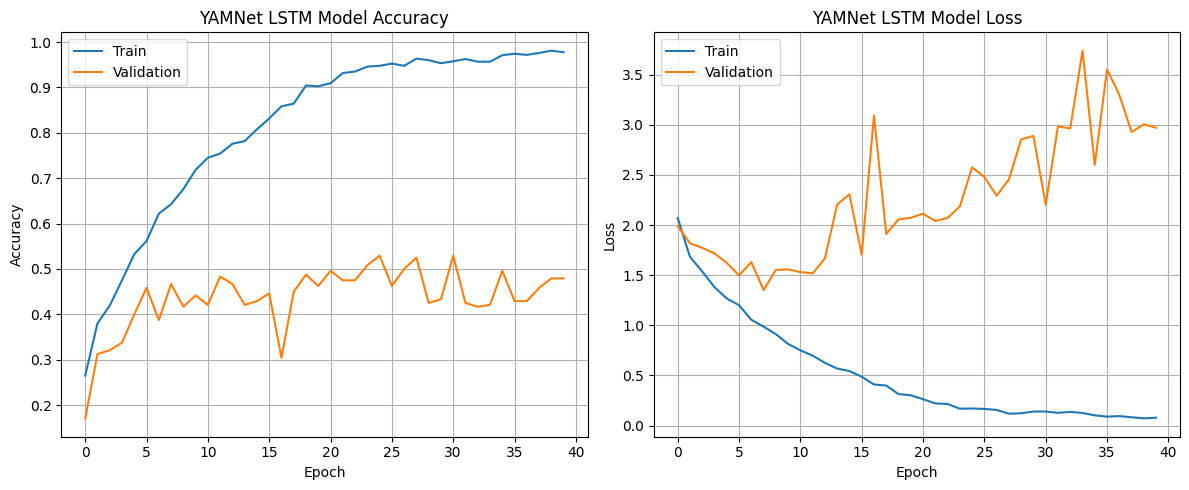

In [ ]:
## Cell (New): Plot YAMNet LSTM Training History

import matplotlib.pyplot as plt

print("\nPlotting YAMNet LSTM training history...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Check if history object exists and has data
if 'history_yamnet_lstm' in locals() and history_yamnet_lstm is not None and history_yamnet_lstm.history:
    # Plot training & validation accuracy values
    if 'accuracy' in history_yamnet_lstm.history and 'val_accuracy' in history_yamnet_lstm.history:
        ax1.plot(history_yamnet_lstm.history['accuracy'])
        ax1.plot(history_yamnet_lstm.history['val_accuracy'])
        ax1.set_title('YAMNet LSTM Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Train', 'Validation'], loc='upper left')
        ax1.grid(True)
    else:
        ax1.set_title('Accuracy data not available')

    # Plot training & validation loss values
    if 'loss' in history_yamnet_lstm.history and 'val_loss' in history_yamnet_lstm.history:
        ax2.plot(history_yamnet_lstm.history['loss'])
        ax2.plot(history_yamnet_lstm.history['val_loss'])
        ax2.set_title('YAMNet LSTM Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Train', 'Validation'], loc='upper left')
        ax2.grid(True)
    else:
        ax2.set_title('Loss data not available')

    plt.tight_layout()
    plt.show()
else:
    print("No training history found to plot.")

Conclusion:
1. Using the sequence of YAMNet embeddings with an LSTM is a better approach than our previous methods for this dataset, but the model is still overfitting heavily to the training speakers.

2. The features learned, while better, are being memorized rather than generalized. The Masking layer helps ignore padding, but the model quickly learns the specific sequences of the training actors.

In [ ]:
## Building LSTM Classifier with Increased Regularization

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Masking, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

sequence_input_shape = (MAX_SEQ_LEN, EMBEDDING_SIZE) # (10, 1024)

yamnet_lstm_classifier = Sequential([
    Input(shape=sequence_input_shape),
    Masking(mask_value=0.0),
    LSTM(128, return_sequences=False),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.6), # <-- Increased dropout rate
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
yamnet_lstm_classifier.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("LSTM classifier model (with increased dropout) built:")
yamnet_lstm_classifier.summary()

LSTM classifier model (with increased dropout) built:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 10, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 608,392 (2.32 MB)

 Trainable params: 608,136 (2.32 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
## Training the LSTM Classifier on YAMNet Sequences

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

# Save the best version of *this* LSTM classifier
yamnet_lstm_checkpoint = ModelCheckpoint(
    'best_yamnet_lstm_classifier.keras', # New filename
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

epochs = 100
batch_size = 32

print("\nStarting training for the LSTM classifier on YAMNet sequences...")

history_yamnet_lstm = yamnet_lstm_classifier.fit(
    X_train_yamnet_seq, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_yamnet_seq, y_test_cat),
    callbacks=[early_stopping, yamnet_lstm_checkpoint]
)

print("\nLSTM Classifier training complete.")

print("Loading best weights achieved during training...")
yamnet_lstm_classifier.load_weights('best_yamnet_lstm_classifier.keras')


Starting training for the LSTM classifier on YAMNet sequences...
Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.1663 - loss: 2.3994 - val_accuracy: 0.2708 - val_loss: 1.9752
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3052 - loss: 1.9072 - val_accuracy: 0.3083 - val_loss: 1.8710
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3444 - loss: 1.7309 - val_accuracy: 0.2792 - val_loss: 1.7853
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4328 - loss: 1.5311 - val_accuracy: 0.3167 - val_loss: 1.7831
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4659 - loss: 1.4520 - val_accuracy: 0.2958 - val_loss: 1.7803
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5001 - loss: 1.3458 - val_accuracy: 0.3125 - val_loss: 1.7396
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5171 - loss: 1.3045 - val_accuracy: 0.2458 - val_loss: 1.9167
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
print("Evaluating the YAMNet LSTM classifier on the test set sequences...")

loss, accuracy = yamnet_lstm_classifier.evaluate(X_test_yamnet_seq, y_test_cat, verbose=0)

print(f"\nTest Loss (YAMNet LSTM): {loss:.4f}")
print(f"Test Accuracy (YAMNet LSTM): {accuracy*100:.2f}%")

final_yamnet_lstm_accuracy = accuracy
final_yamnet_lstm_loss = loss

Evaluating the YAMNet LSTM classifier on the test set sequences...

Test Loss (YAMNet LSTM): 2.3123
Test Accuracy (YAMNet LSTM): 50.83%



Plotting YAMNet LSTM training history...


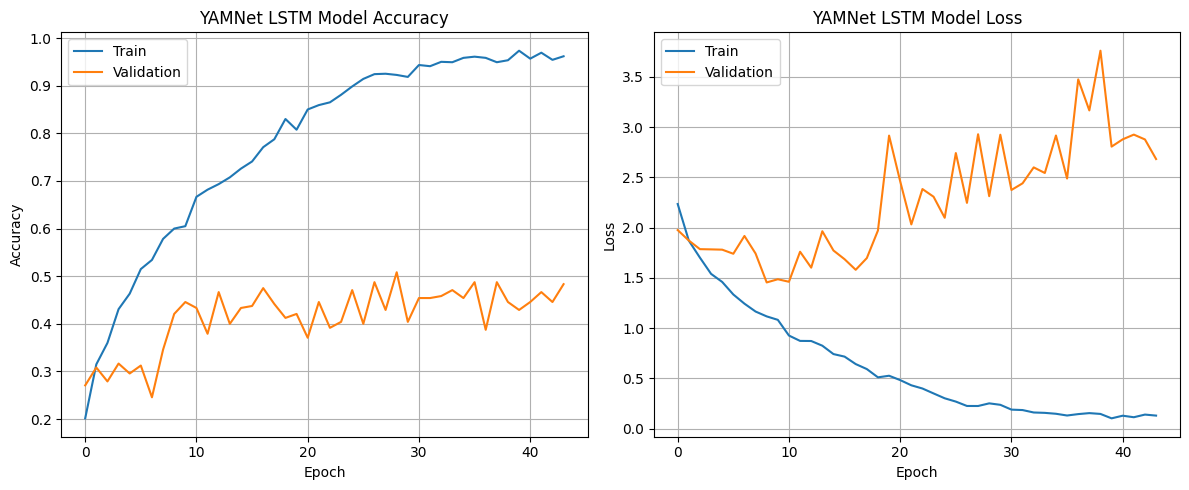

In [ ]:
# Plotting YAMNet LSTM Training History

import matplotlib.pyplot as plt

print("\nPlotting YAMNet LSTM training history...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Check if history object exists and has data
if 'history_yamnet_lstm' in locals() and history_yamnet_lstm is not None and history_yamnet_lstm.history:
    # Plot training & validation accuracy values
    if 'accuracy' in history_yamnet_lstm.history and 'val_accuracy' in history_yamnet_lstm.history:
        ax1.plot(history_yamnet_lstm.history['accuracy'])
        ax1.plot(history_yamnet_lstm.history['val_accuracy'])
        ax1.set_title('YAMNet LSTM Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Train', 'Validation'], loc='upper left')
        ax1.grid(True)
    else:
        ax1.set_title('Accuracy data not available')

    # Plott training & validation loss values
    if 'loss' in history_yamnet_lstm.history and 'val_loss' in history_yamnet_lstm.history:
        ax2.plot(history_yamnet_lstm.history['loss'])
        ax2.plot(history_yamnet_lstm.history['val_loss'])
        ax2.set_title('YAMNet LSTM Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Train', 'Validation'], loc='upper left')
        ax2.grid(True)
    else:
        ax2.set_title('Loss data not available')

    plt.tight_layout()
    plt.show()
else:
    print("No training history found to plot.")

**Conclusion**

Simply increasing the dropout rate to 0.6 was not effective in controlling the overfitting. The model is still memorizing the training speaker characteristics rather than learning general emotional patterns from the YAMNet sequences. The validation performance remains poor and unstable

In [ ]:
## Building LSTM Classifier with Sequence Dropout

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Masking, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

sequence_input_shape = (MAX_SEQ_LEN, EMBEDDING_SIZE) # (10, 1024)

yamnet_lstm_classifier = Sequential([
    Input(shape=sequence_input_shape),
    Masking(mask_value=0.0),
    # Add dropout after masking, before LSTM
    Dropout(0.3),
    LSTM(128, return_sequences=False, recurrent_dropout=0.3), # Dropout on recurrent connections
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.6), # Keep the increased dropout after Dense
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
yamnet_lstm_classifier.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("LSTM classifier model (with sequence dropout) built:")
yamnet_lstm_classifier.summary()

LSTM classifier model (with sequence dropout) built:


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_2 (Masking)             │ (None, 10, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 128)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 608,392 (2.32 MB)

 Trainable params: 608,136 (2.32 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
# Training the LSTM Classifier on YAMNet Sequences

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # Ensure callbacks are imported

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)

yamnet_lstm_checkpoint = ModelCheckpoint(
    'best_yamnet_lstm_classifier.keras', # New filename
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

epochs = 100 # Allow ample training time, early stopping will manage it
batch_size = 32

print("\nStarting training for the LSTM classifier on YAMNet sequences...")

history_yamnet_lstm = yamnet_lstm_classifier.fit(
    X_train_yamnet_seq, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test_yamnet_seq, y_test_cat),
    callbacks=[early_stopping, yamnet_lstm_checkpoint]
)

print("\nLSTM Classifier training complete.")

print("Loading best weights achieved during training...")
yamnet_lstm_classifier.load_weights('best_yamnet_lstm_classifier.keras')


Starting training for the LSTM classifier on YAMNet sequences...
Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 57ms/step - accuracy: 0.1604 - loss: 2.6046 - val_accuracy: 0.1417 - val_loss: 2.0225
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.2516 - loss: 2.0676 - val_accuracy: 0.1625 - val_loss: 2.0141
Epoch 3/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.3333 - loss: 1.8093 - val_accuracy: 0.1875 - val_loss: 1.9335
Epoch 4/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3592 - loss: 1.6940 - val_accuracy: 0.3542 - val_loss: 1.7783
Epoch 5/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4079 - loss: 1.6176 - val_accuracy: 0.3042 - val_loss: 1.7980
Epoch 6/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4490 - loss: 1.5199 - val_accuracy: 0.4125 - val_loss: 1.6583
Epoch 7/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.4651 - loss: 1.4348 - val_accuracy: 0.4458 - val_loss: 1.5850
Epoch 8/100
38/38 ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Evaluating the YAMNet LSTM Classifier

print("Evaluating the YAMNet LSTM classifier on the test set sequences...")

loss, accuracy = yamnet_lstm_classifier.evaluate(X_test_yamnet_seq, y_test_cat, verbose=0)

print(f"\nTest Loss (YAMNet LSTM): {loss:.4f}")
print(f"Test Accuracy (YAMNet LSTM): {accuracy*100:.2f}%")

final_yamnet_lstm_accuracy = accuracy
final_yamnet_lstm_loss = loss

Evaluating the YAMNet LSTM classifier on the test set sequences...

Test Loss (YAMNet LSTM): 1.4307
Test Accuracy (YAMNet LSTM): 53.75%



Plotting YAMNet LSTM training history...


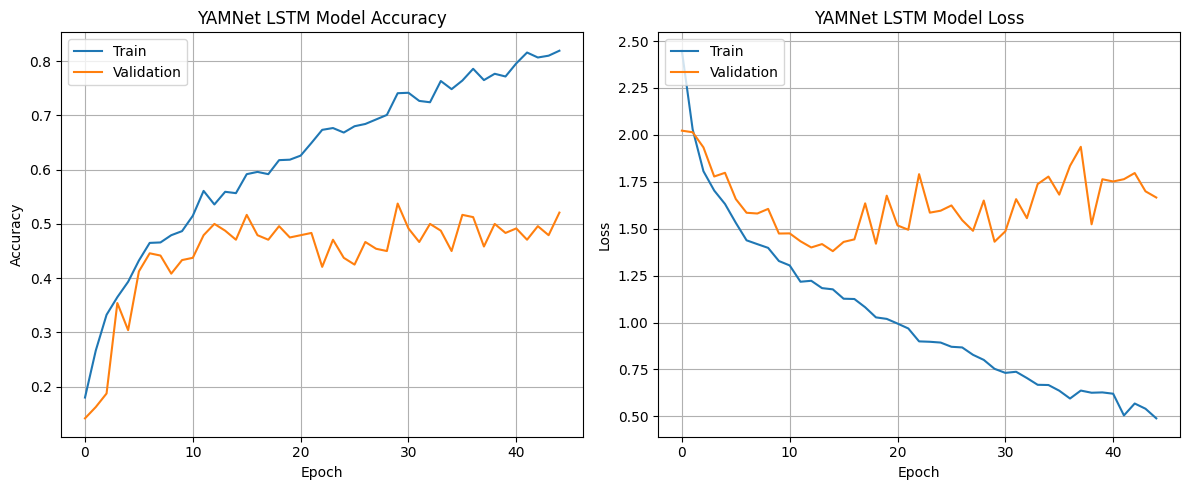

In [ ]:
import matplotlib.pyplot as plt

print("\nPlotting YAMNet LSTM training history...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Check if history object exists and has data
if 'history_yamnet_lstm' in locals() and history_yamnet_lstm is not None and history_yamnet_lstm.history:
    # Plotting training & validation accuracy values
    if 'accuracy' in history_yamnet_lstm.history and 'val_accuracy' in history_yamnet_lstm.history:
        ax1.plot(history_yamnet_lstm.history['accuracy'])
        ax1.plot(history_yamnet_lstm.history['val_accuracy'])
        ax1.set_title('YAMNet LSTM Model Accuracy')
        ax1.set_ylabel('Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.legend(['Train', 'Validation'], loc='upper left')
        ax1.grid(True)
    else:
        ax1.set_title('Accuracy data not available')

    # Plot training & validation loss values
    if 'loss' in history_yamnet_lstm.history and 'val_loss' in history_yamnet_lstm.history:
        ax2.plot(history_yamnet_lstm.history['loss'])
        ax2.plot(history_yamnet_lstm.history['val_loss'])
        ax2.set_title('YAMNet LSTM Model Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        ax2.legend(['Train', 'Validation'], loc='upper left')
        ax2.grid(True)
    else:
        ax2.set_title('Loss data not available')

    plt.tight_layout()
    plt.show()
else:
    print("No training history found to plot.")

# **Conclusion:**
Adding dropout within the sequential part of the model (before and inside the LSTM) provided a marginal benefit (slightly better loss, tiny accuracy bump) but did not solve the fundamental overfitting problem

# **THE NEXT LOGICAL STEP:
TO implement data augmentation on the input spectrograms before they go into YAMNet. This means building the tf.data pipeline we discussed. It's more complex, but it's the most direct way to tackle the overfitting at its source.**

In [ ]:
import tensorflow as tf
import numpy as np

YAMNET_SR = 16000
N_MELS = 128
MAX_WAV_SAMPLES = int(5 * YAMNET_SR)
FFT_LENGTH = 1024
HOP_LENGTH = 512

@tf.function
def load_wav_and_spectrogram(filepath):
    file_contents = tf.io.read_file(filepath)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)

    wav = wav[:MAX_WAV_SAMPLES]
    zero_padding = tf.zeros([MAX_WAV_SAMPLES] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([wav, zero_padding], 0)
    wav.set_shape([MAX_WAV_SAMPLES])

    # 4. Compute STFT
    stfts = tf.signal.stft(
        wav, frame_length=FFT_LENGTH, frame_step=HOP_LENGTH, fft_length=FFT_LENGTH
    )
    spectrograms = tf.abs(stfts)

    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz = 80.0, 7600.0
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        N_MELS, num_spectrogram_bins, tf.cast(YAMNET_SR, tf.float32),
        lower_edge_hertz, upper_edge_hertz
    )
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
        linear_to_mel_weight_matrix.shape[-1:]))

    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)

    return log_mel_spectrograms

def load_resample_with_librosa(filepath):
    filepath_str = filepath.numpy().decode('utf-8')
    wav_data, sr = librosa.load(filepath_str, sr=YAMNET_SR, mono=True)
    return wav_data

@tf.function
def load_audio_tf_py(filepath):
    wav_data = tf.py_function(
        load_resample_with_librosa,
        [filepath],
        tf.float32
    )
    wav_data.set_shape([None])

    wav = wav_data[:MAX_WAV_SAMPLES]
    zero_padding = tf.zeros([MAX_WAV_SAMPLES] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([wav, zero_padding], 0)
    wav.set_shape([MAX_WAV_SAMPLES])

    stfts = tf.signal.stft(wav, frame_length=FFT_LENGTH, frame_step=HOP_LENGTH, fft_length=FFT_LENGTH)
    spectrograms = tf.abs(stfts)
    num_spectrogram_bins = stfts.shape[-1]
    lower_edge_hertz, upper_edge_hertz = 80.0, 7600.0
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        N_MELS, num_spectrogram_bins, tf.cast(YAMNET_SR, tf.float32),
        lower_edge_hertz, upper_edge_hertz
    )
    mel_spectrograms = tf.tensordot(spectrograms, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrograms.shape[:-1].concatenate(
        linear_to_mel_weight_matrix.shape[-1:]))
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)


    TARGET_WIDTH = MAX_PAD_LEN
    spec = log_mel_spectrograms
    current_width = tf.shape(spec)[0]
    spec = tf.transpose(spec, perm=[1, 0])

    if tf.shape(spec)[1] > TARGET_WIDTH:
      spec = spec[:, :TARGET_WIDTH]
    else:
      pad_width = TARGET_WIDTH - tf.shape(spec)[1]
      spec = tf.pad(spec, paddings=[[0, 0], [0, pad_width]], mode='CONSTANT')

    spec.set_shape([N_MELS, TARGET_WIDTH])

    return spec

print("Audio loading and spectrogram functions defined.")

Audio loading and spectrogram functions defined.


In [ ]:
def spec_augment(spectrogram, time_mask_param=40, freq_mask_param=15, num_time_masks=1, num_freq_masks=1):
    """Applies SpecAugment (Time and Frequency Masking)."""
    freq_bins, time_steps = tf.shape(spectrogram)[0], tf.shape(spectrogram)[1]

    for _ in range(num_freq_masks):
        f = tf.random.uniform([], minval=0, maxval=freq_mask_param, dtype=tf.int32)
        f0 = tf.random.uniform([], minval=0, maxval=freq_bins - f, dtype=tf.int32)
        mask_end = f0 + f
        freq_mask_indices = tf.range(f0, mask_end)
        freq_mask_bool = tf.reduce_all(tf.not_equal(tf.range(freq_bins)[:, None], freq_mask_indices), axis=1)
        freq_mask = tf.cast(freq_mask_bool, spectrogram.dtype)[:, tf.newaxis]
        spectrogram = spectrogram * freq_mask

    for _ in range(num_time_masks):
        t = tf.random.uniform([], minval=0, maxval=time_mask_param, dtype=tf.int32)
        t0 = tf.random.uniform([], minval=0, maxval=time_steps - t, dtype=tf.int32)
        mask_end = t0 + t
        time_mask_indices = tf.range(t0, mask_end)
        time_mask_bool = tf.reduce_all(tf.not_equal(tf.range(time_steps)[None, :], time_mask_indices[:, None]), axis=0)
        time_mask = tf.cast(time_mask_bool, spectrogram.dtype)[tf.newaxis, :]
        spectrogram = spectrogram * time_mask

    return spectrogram

print("SpecAugment function defined.")

SpecAugment function defined.


In [ ]:
@tf.function
def yamnet_embeddings_from_spec(log_mel_spectrogram):
    @tf.function
    def load_resampled_waveform(filepath):
        wav_data = tf.py_function(
            load_resample_with_librosa, [filepath], tf.float32
        )
        wav_data.set_shape([None])
        wav = wav_data[:MAX_WAV_SAMPLES]
        zero_padding = tf.zeros([MAX_WAV_SAMPLES] - tf.shape(wav), dtype=tf.float32)
        wav = tf.concat([wav, zero_padding], 0)
        wav.set_shape([MAX_WAV_SAMPLES])
        return wav

    @tf.function
    def get_yamnet_sequence(filepath):
      waveform = load_resampled_waveform(filepath)
      _, embeddings, _ = yamnet_model(waveform)
      embeddings_np = embeddings.numpy()
      padded_embeddings = pad_sequences(
          [embeddings_np], maxlen=MAX_SEQ_LEN, dtype='float32',
          padding='post', truncating='post'
      )[0]
      return padded_embeddings
    pass

print("YAMNet embedding wrapper function placeholder defined (will integrate in pipeline).")

YAMNet embedding wrapper function placeholder defined (will integrate in pipeline).


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences # Ensure imported

train_filepaths = df['path'][train_mask].tolist()
test_filepaths = df['path'][test_mask].tolist()
y_train_numeric = y[train_mask]
y_test_numeric = y[test_mask]

def process_path(filepath, label, is_training):
    waveform = tf.py_function(load_resample_with_librosa, [filepath], tf.float32)
    waveform.set_shape([None])
    wav = waveform[:MAX_WAV_SAMPLES]
    zero_padding = tf.zeros([MAX_WAV_SAMPLES] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([wav, zero_padding], 0)
    wav.set_shape([MAX_WAV_SAMPLES])

    _, embeddings, _ = yamnet_model(wav)

    def pad_np_sequence(embedding_tensor):
        embeddings_np = embedding_tensor.numpy()
        padded = pad_sequences(
            [embeddings_np], maxlen=MAX_SEQ_LEN, dtype='float32',
            padding='post', truncating='post'
        )[0]
        return padded

    padded_embeddings = tf.py_function(
        pad_np_sequence,
        [embeddings],
        tf.float32
    )
    padded_embeddings.set_shape([MAX_SEQ_LEN, EMBEDDING_SIZE]) # (10, 1024)

    label_one_hot = tf.one_hot(label, depth=num_classes)
    return padded_embeddings, label_one_hot

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32

ds_train_aug = tf.data.Dataset.from_tensor_slices((train_filepaths, y_train_numeric))
ds_train_aug = ds_train_aug.shuffle(len(train_filepaths)) # Shuffle paths first
ds_train_aug = ds_train_aug.map(lambda x, y: process_path(x, y, is_training=True), num_parallel_calls=AUTOTUNE)
ds_train_aug = ds_train_aug.cache() # Cache after loading/processing/augmenting
ds_train_aug = ds_train_aug.batch(batch_size)
ds_train_aug = ds_train_aug.prefetch(AUTOTUNE)

ds_test_aug = tf.data.Dataset.from_tensor_slices((test_filepaths, y_test_numeric))
ds_test_aug = ds_test_aug.map(lambda x, y: process_path(x, y, is_training=False), num_parallel_calls=AUTOTUNE)
ds_test_aug = ds_test_aug.cache()
ds_test_aug = ds_test_aug.batch(batch_size) # Use same batch size or larger
ds_test_aug = ds_test_aug.prefetch(AUTOTUNE)

print("\nTraining and validation tf.data pipelines created.")


Training and validation tf.data pipelines created.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Masking, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

sequence_input_shape = (MAX_SEQ_LEN, EMBEDDING_SIZE) # (10, 1024)

yamnet_lstm_classifier = Sequential([
    Input(shape=sequence_input_shape),
    Masking(mask_value=0.0),
    Dropout(0.3),
    LSTM(128, return_sequences=False, recurrent_dropout=0.3),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
yamnet_lstm_classifier.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("LSTM classifier model for YAMNet sequences built/rebuilt:")
yamnet_lstm_classifier.summary()

LSTM classifier model for YAMNet sequences built/rebuilt:


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)             │ (None, 10, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 128)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 608,392 (2.32 MB)

 Trainable params: 608,136 (2.32 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

tfdata_checkpoint = ModelCheckpoint(
    'best_tfdata_yamnet_lstm.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

epochs = 100

print("\nStarting training using tf.data pipelines...")

history_tfdata = yamnet_lstm_classifier.fit(
    ds_train_aug, # Training dataset pipeline
    epochs=epochs,
    validation_data=ds_test_aug, # Validation dataset pipeline
    callbacks=[early_stopping, tfdata_checkpoint]
)

print("\nTraining with tf.data complete.")

print("Loading best weights achieved during tf.data training...")
try:
    yamnet_lstm_classifier.load_weights('best_tfdata_yamnet_lstm.keras')
    print("Best weights loaded successfully.")
except Exception as e:
    print(f"Could not load best weights: {e}. Using weights from end of training.")


Starting training using tf.data pipelines...
Epoch 1/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1468 - loss: 2.6372
Epoch 1: val_accuracy improved from -inf to 0.19583, saving model to best_tfdata_yamnet_lstm.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.1471 - loss: 2.6326 - val_accuracy: 0.1958 - val_loss: 2.0474
Epoch 2/100
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2117 - loss: 2.0867
Epoch 2: val_accuracy improved from 0.19583 to 0.21667, saving model to best_tfdata_yamnet_lstm.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.2123 - loss: 2.0851 - val_accuracy: 0.2167 - val_loss: 1.9439
Epoch 3/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3095 - loss: 1.8630
Epoch 3: val_accuracy improved from 0.21667 to 0.36667, saving model to best_tfdata_yamnet_lstm.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.3096 - loss: 1.8624 - val_accuracy: 0.3667 - val_loss: 1.8601
Epoch 4/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/s

In [ ]:
# Evaluating

print("\nEvaluating the final model (trained with tf.data)...")

loss, accuracy = yamnet_lstm_classifier.evaluate(ds_test_aug, verbose=0)

print(f"\nTest Loss (tf.data YAMNet LSTM): {loss:.4f}")
print(f"Test Accuracy (tf.data YAMNet LSTM): {accuracy*100:.2f}%")


Evaluating the final model (trained with tf.data)...

Test Loss (tf.data YAMNet LSTM): 1.4924
Test Accuracy (tf.data YAMNet LSTM): 47.92%


I am stopping here as the Accuracy is not improving I will try more Alternative Approaches